In [ ]:
import pandas as pd
import numpy as np

from src.populate_db import connect_to_database
from src.analysis_utils import get_words_by_genre, get_word_cloud, get_sentiment

import warnings
warnings.filterwarnings('ignore')

# Exploring Songs

This notebook will answer some basic questions about the songs in the database:
* Do the words in the song titles change depending on genre?
* What are the emotions associated with the songs' titles?

Let's query the database and load the data into a dataframe.

In [2]:
conn = connect_to_database()
cursor = conn.cursor()
cursor.execute("""
               SELECT song.name as song_name, band.name as band_name, genre.genre_name 
               FROM song 
               INNER JOIN band ON song.band_id=band.id 
               INNER JOIN band_genre ON band.id = band_genre.band_id 
               INNER JOIN genre ON band_genre.genre_id = genre.id;
               """)
songs = cursor.fetchall()

In [14]:
songs_df = pd.DataFrame(songs, columns=['Song', 'Band', 'Genre'])

## Do the words in the song titles change depending on genre?

Let's create word clouds for five popular genres in the database to check which words are more frequent in each genre's songs.

Thrash Metal


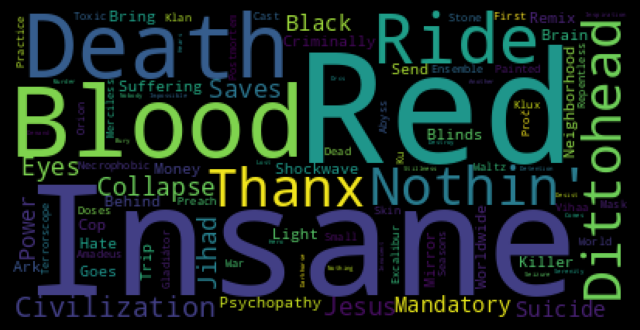

Heavy Metal


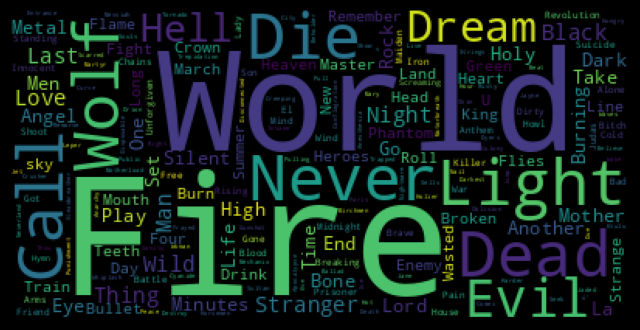

Gothic Metal


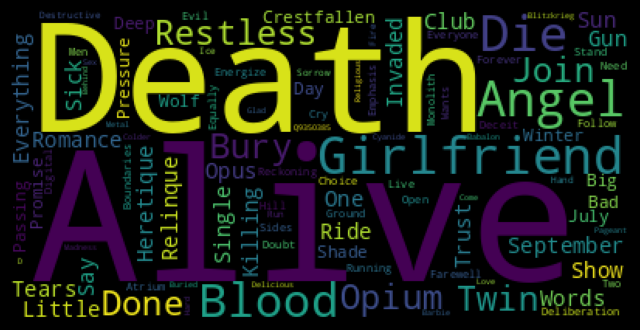

Death Metal


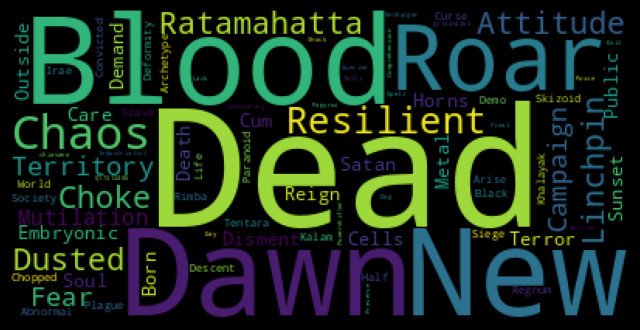

Progressive Metal


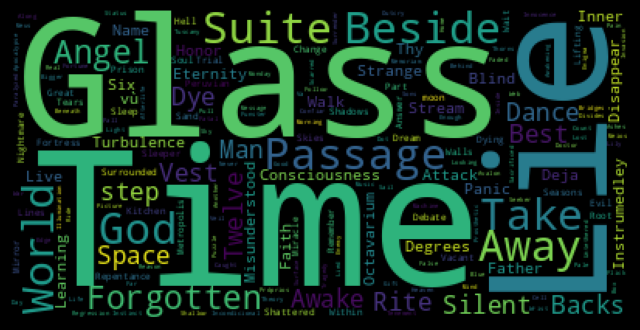

In [15]:
genres = ['thrash metal', 'heavy metal', 'gothic metal', 'death metal', 'progressive metal']
songs_df = songs_df.drop_duplicates(subset=['Song', 'Band'])
words = {genre: get_words_by_genre(songs_df, 'Song', genre) for genre in genres}

for genre in genres:
    print(genre.title())
    get_word_cloud(words[genre])

Although the words are different, we can notice the common theme of death, represented by words such as "death", "blood", "fire", "dead", and "alive". Words like "evil", "insane", "chaos", "restless", "tears", and "lie" also point to the existence of negative emotions on the song titles.

The words in the song titles also somewhat reflect differences in the themes usually present in different genres, with words illustrating death, aggressiveness, and darkness in genres like Thrash and Death Metal ("death", "dead", "blood", "insane", "psychopathy", "dawn"), life and death in gothic metal ("death", "alive", "angel", "girlfriend", "tears"). 

For Heavy Metal, we see words symbolizing power, empowerment, death, rebellion, violence, such as "fire", "world", "light", "dream", "dead", "evil", "hell", "die". 

Finally, the words in Progressive Metal song titles may reflect fantasy or sci-fi themes and existential or philosophical questions ("time", "passage", "awake", "rite", "space", "god", "angel", "forgotten", "lie", "world"), as this genre tends to be more experimental and diverse.

## What are the emotions associated with the songs' titles?

To further understand our songs titles, let's also perform a [zero-shot classification](https://huggingface.co/tasks/zero-shot-classification) of six emotions (anxiety, depression, happiness, love, anger, and hope) based on the titles by genre. We'll be using [a Facebook's BART checkpoint](https://huggingface.co/facebook/bart-large-mnli) for this task.


In [69]:
song_sentiment = []
labels = ["anxiety", "depression", "happiness", "love", "anger", "hope"]

for genre in genres:
    genre_data = songs_df['Song'][songs_df['Genre'] == genre]
    sentiments = [get_sentiment(song, labels) for song in genre_data if type(song) == str and len(song) > 0]
    sentiments = [
        {'Song': item['sequence'], **dict(zip(item['labels'], item['scores'])), 'Genre': genre}
        for item in sentiments
    ]
    song_sentiment.extend(sentiments)

Let's take the mean score for each sentiment grouped by genre so we can visualize the results more easily. It's also a good idea to save the results for further inspection.

In [172]:
song_sentiment = pd.DataFrame(song_sentiment)
song_sentiment_df = song_sentiment.groupby('Genre')[labels].mean()

song_sentiment.to_csv('data/song_sentiment.csv', index=False)

Now let's plot the results!

Anger was the higher scoring emotion in the song titles, surprisingly followed by hope. Next we have anxiety and depression. Love and happiness got the lowest scores, as one would expect.

<Axes: title={'center': 'Distribution of Sentiments in the Song Titles'}>

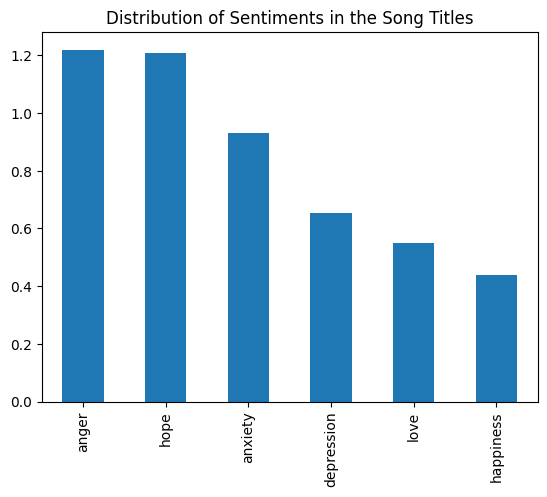

In [170]:
song_sentiment_df.sum().sort_values(ascending=False).plot(kind='bar', title='Distribution of Sentiments in the Song Titles')

<Axes: title={'center': 'Sentiment Analysis by Genre'}>

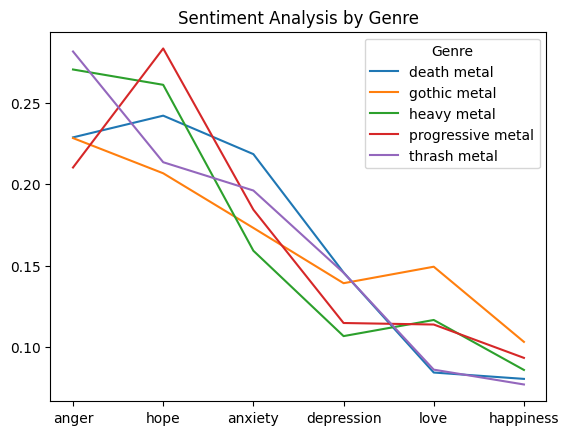

In [171]:
song_sentiment_df.transpose().sort_values(by='thrash metal', ascending=False).plot(title='Sentiment Analysis by Genre')

When it comes to sentiment by genre, anger was the higher scoring emotion for Thrash, Heavy, and Gothic Metal, and the second highest for Death and Progressive Metal. This confirms anger as the most dominant emotion accross subgenres, reflecting the agressive sound and themes related to rebellion and defiance.

Progressive Metal had the highest score on hope, followed by Heavy Metal. As mentioned earlier, this was the second overall highest scoring emotion. Although this was unanticipated, it may reflect the desire for change that comes from songs with socio-political content. It is also in line with the deeper and more introspective narrative that is sometimes present Progressive Metal.

Anxiety and depression were highly prevalent emotions in Death and Thrash Metal titles, which were also the least loving and happy of the investigated genres. This might be explain by the fact that these genres often explore themes related to agressiveness, violence, and existential dread.

Gothic Metal shows the least variation across the investigated emotions and a peak on love compared to the others genres. This may reflect a tendency of blending romanticism with darker emotions, such as anger and melancholy, resulting in an unique emotional profile.

It is important to remember, however, that this classification is based in a model trained on general text, so the conclusions we can draw from it are limited. Moreover, fans and non-fans of heavy metal may experience different emotions while listening to violent-themed music ([Thompson et al., 2019](https://psycnet.apa.org/doiLanding?doi=10.1037%2Fppm0000184)), so these results should not be interpreted as a reflection of the listener's emotions.